<a href="https://colab.research.google.com/github/capriate123/task/blob/main/TAsk2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<ipython-input-1-7e7412500f59>:19: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-1-7e7412500f59>:20: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
<ipython-input-1-7e7412500f59>:35: RuntimeWarning: invalid value encountered in sqrt
  d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
<ipython-input-1-7e7412500f59>:36: RuntimeWarning: invalid value encountered in sqrt
  d2 = d1 - sigma * np.sqrt(T)
<ipython-input-1-7e7412500f59>:40: RuntimeWarning: invalid value encountered in sqrt
  vega = S * norm.pdf(d1) * np.sqrt(T)
<ipython-input-1-7e7412500f59>:41: RuntimeWarning: invalid value encountered in sqrt
  theta = -(S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * norm.cdf(d2)


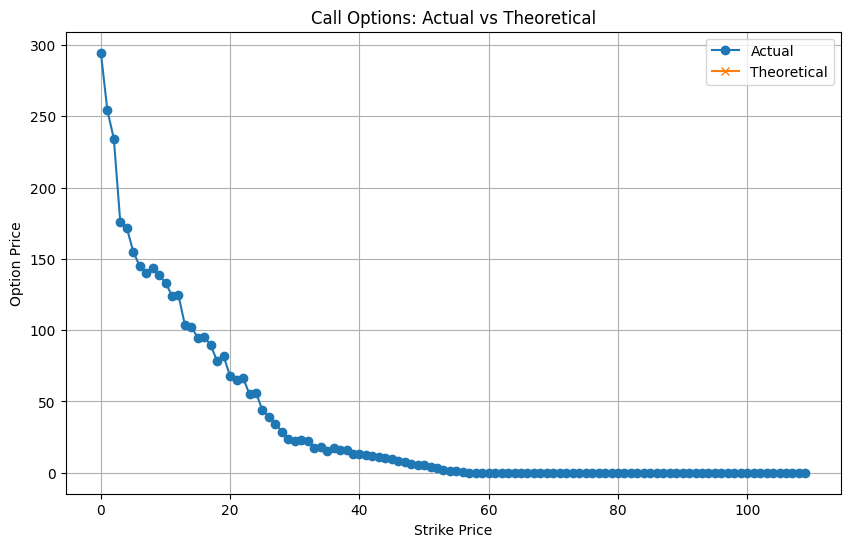

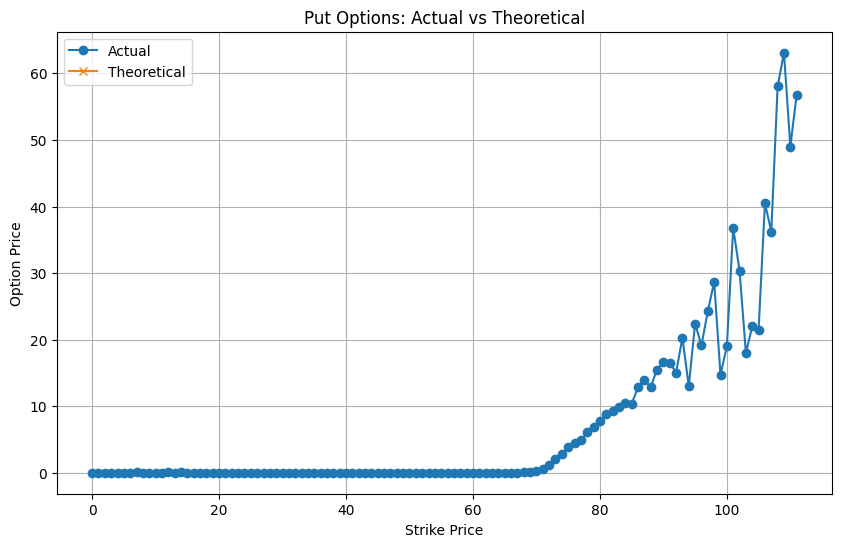

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import yfinance as yf
from scipy.stats import norm

# Black-Scholes Model Implementation
def black_scholes(S, K, T, r, sigma, option_type="call"):
    """
    Calculate Black-Scholes option price.
    :param S: Current stock price
    :param K: Strike price
    :param T: Time to maturity (in years)
    :param r: Risk-free rate
    :param sigma: Volatility of the stock
    :param option_type: "call" or "put"
    :return: Option price
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    if option_type == "call":
        return S * norm.cdf(d1) - K * np.exp(-r * T) * norm.cdf(d2)
    elif option_type == "put":
        return K * np.exp(-r * T) * norm.cdf(-d2) - S * norm.cdf(-d1)
    else:
        raise ValueError("Invalid option type. Use 'call' or 'put'.")

# Greeks Calculation
def calculate_greeks(S, K, T, r, sigma):
    """
    Calculate option Greeks.
    :return: Dictionary of Greeks
    """
    d1 = (np.log(S / K) + (r + 0.5 * sigma ** 2) * T) / (sigma * np.sqrt(T))
    d2 = d1 - sigma * np.sqrt(T)

    delta = norm.cdf(d1) if T > 0 else 0
    gamma = norm.pdf(d1) / (S * sigma * np.sqrt(T)) if T > 0 else 0
    vega = S * norm.pdf(d1) * np.sqrt(T)
    theta = -(S * norm.pdf(d1) * sigma / (2 * np.sqrt(T))) - r * K * np.exp(-r * T) * norm.cdf(d2)
    rho = K * T * np.exp(-r * T) * norm.cdf(d2)

    return {"Delta": delta, "Gamma": gamma, "Vega": vega, "Theta": theta, "Rho": rho}

# Fetching Stock Data and Option Chains
def fetch_data(ticker, start_date, end_date):
    """Fetch historical stock and option data from Yahoo Finance."""
    stock = yf.Ticker(ticker)

    # Fetch historical price data
    stock_data = stock.history(start=start_date, end=end_date)

    # Fetch option expiration dates
    expiries = stock.options

    # Fetch options data for each expiry
    options_data = {}
    for expiry in expiries:
        try:
            opt_chain = stock.option_chain(expiry)
            options_data[expiry] = {
                "calls": opt_chain.calls,
                "puts": opt_chain.puts,
            }
        except Exception as e:
            print(f"Error fetching options for expiry {expiry}: {e}")

    return stock_data, options_data

# Plot Actual vs. Theoretical Prices
def plot_prices(actual, theoretical, title):
    plt.figure(figsize=(10, 6))
    plt.plot(actual, label="Actual", marker="o")
    plt.plot(theoretical, label="Theoretical", marker="x")
    plt.title(title)
    plt.xlabel("Strike Price")
    plt.ylabel("Option Price")
    plt.legend()
    plt.grid()
    plt.show()

# Main Execution
if __name__ == "__main__":
    # Parameters
    ticker = "SPY"  # SPDR S&P 500 ETF
    start_date = "2024-06-01"
    end_date = "2024-12-01"
    risk_free_rate = 0.05  # 5% annual risk-free rate

    # Fetch data
    stock_data, options_data = fetch_data(ticker, start_date, end_date)

    # Example Analysis for a single expiry
    expiry = list(options_data.keys())[0]  # First expiry date
    call_data = options_data[expiry]["calls"]
    put_data = options_data[expiry]["puts"]

    # Calculate theoretical prices and Greeks
    theoretical_calls = []
    theoretical_puts = []
    greeks_data = []

    for _, row in call_data.iterrows():
        S = stock_data["Close"].iloc[-1]  # Latest stock price
        K = row["strike"]
        T = (pd.to_datetime(expiry) - pd.Timestamp.now()).days / 365.0
        sigma = 0.2  # Approximate volatility

        call_price = black_scholes(S, K, T, risk_free_rate, sigma, option_type="call")
        put_price = black_scholes(S, K, T, risk_free_rate, sigma, option_type="put")

        theoretical_calls.append(call_price)
        theoretical_puts.append(put_price)
        greeks_data.append(calculate_greeks(S, K, T, risk_free_rate, sigma))

    # Plot prices
    plot_prices(call_data["lastPrice"], theoretical_calls, "Call Options: Actual vs Theoretical")
    plot_prices(put_data["lastPrice"], theoretical_puts, "Put Options: Actual vs Theoretical")
